In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [201]:
def retrieve_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start = start_date, end = end_date)
    return data

In [202]:
stock_data = retrieve_stock_data("NVDA", "2020-01-01","2025-01-01")


[*********************100%***********************]  1 of 1 completed


In [203]:
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.972710,5.972710,5.893293,5.943831,237536000
2020-01-03,5.877113,5.920929,5.828068,5.852964,205384000
2020-01-06,5.901759,5.906987,5.757613,5.783754,262636000
2020-01-07,5.973208,6.019016,5.885078,5.930139,314856000
2020-01-08,5.984412,6.025739,5.928895,5.968976,277108000


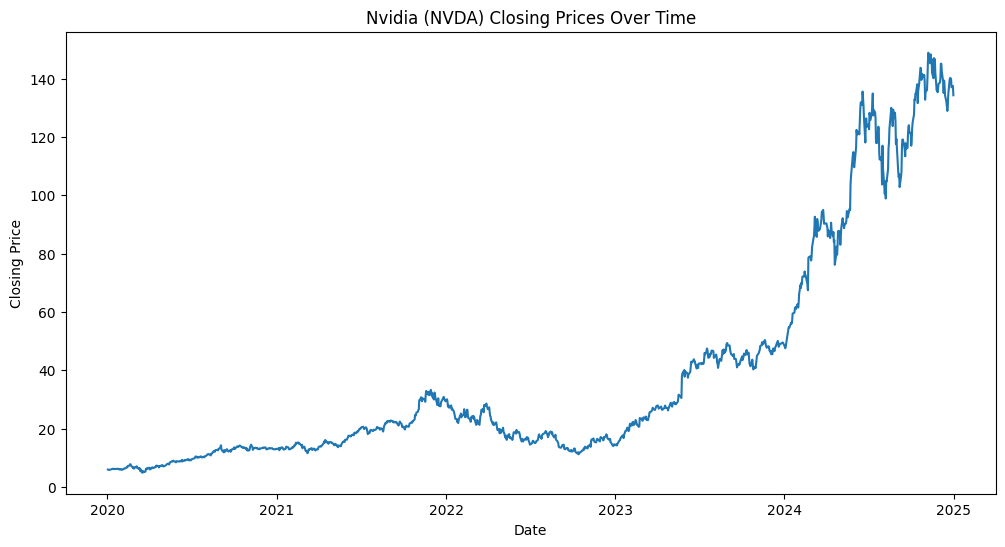

In [204]:
plt.figure(figsize=(12,6))
plt.plot(stock_data["Close"])
plt.title("Nvidia (NVDA) Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [205]:
log_returns = np.log(stock_data['Close']).diff()
train_size = int(len(log_returns) * 0.8)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]

train_data = train_data.dropna()
test_data = test_data.dropna()

In [206]:
# calculate volatility
def calculate_volatility(returns, window=21):
    """Calculate rolling volatility of returns"""
    return returns.rolling(window=window).std() * np.sqrt(252) 

log_returns = np.log(stock_data['Close']).diff()
train_size = int(len(log_returns) * 0.8)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]

train_data = train_data.dropna()
test_data = test_data.dropna()

historical_volatility = calculate_volatility(log_returns)

# ARIMA model
model = ARIMA(train_data, order=(2, 1, 2))
model_fit = model.fit()

c:\Users\danie\OneDrive\Desktop\stockforecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danie\OneDrive\Desktop\stockforecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danie\OneDrive\Desktop\stockforecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danie\OneDrive\Desktop\stockforecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

In [207]:
# generate forecasts
n_periods = 180
forecasted_returns = model_fit.forecast(steps=n_periods)

# calculate historical volatility with more conservative scaling
historical_vol = log_returns.rolling(window=21).std() * np.sqrt(12) 
current_vol = historical_vol.iloc[-1]

# returns back to prices
last_price = float(stock_data['Close'].iloc[-1])
forecasted_prices = []
upper_bound = []
lower_bound = []
current_price = last_price

forecasted_returns = np.array(forecasted_returns)

for i in range(n_periods):
    # calculate price
    current_price = current_price * np.exp(forecasted_returns[i])
    forecasted_prices.append(current_price)
    
    time_factor = np.sqrt((i + 1)/(12 * 21)) 
    std_dev = current_vol * time_factor
    
    upper = current_price * np.exp(1.28 * std_dev)
    lower = current_price * np.exp(-1.28 * std_dev)
    lower = np.maximum(lower, current_price * 0.5) 
    
    upper_bound.append(float(upper)) 
    lower_bound.append(float(lower)) 

# forecast dataframe with proper dates
forecast_dates = pd.date_range(start=stock_data.index[-1], periods=n_periods, freq='D')
forecast_dataframe = pd.DataFrame({'Date': forecast_dates, 'Forecasted': forecasted_prices, 'Upper_Bound': upper_bound, 'Lower_Bound': lower_bound})

c:\Users\danie\OneDrive\Desktop\stockforecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\danie\OneDrive\Desktop\stockforecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\danie\AppData\Local\Temp\ipykernel_18828\1852255891.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])
C:\Users\danie\AppData\Local\Temp\ipykernel_18828\1852255891.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future.

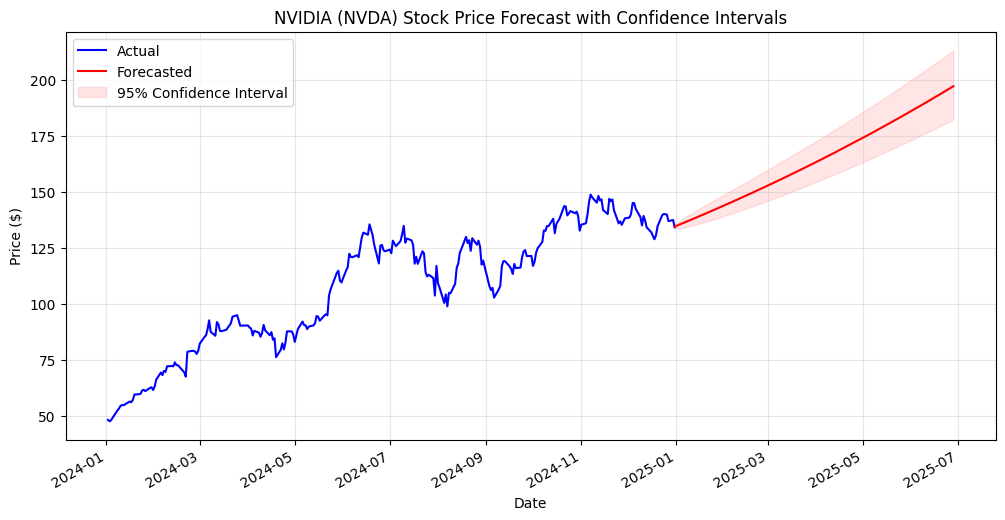


Forecast Summary:
Current Price: $134.29
Forecasted Price (180 days): $197.30
Upper Bound (95% CI): $213.35
Lower Bound (95% CI): $182.46

Historical Volatility (Last 21 days): 7.23%


C:\Users\danie\AppData\Local\Temp\ipykernel_18828\149520682.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"\nHistorical Volatility (Last 21 days): {float(historical_vol.iloc[-1]*100):.2f}%")


In [208]:
# plot with confidence intervals
plt.figure(figsize=(12, 6))
# plot actual data
plt.plot(stock_data.index[-252:], stock_data['Close'][-252:], label='Actual', color='b')
# plot forecast
plt.plot(forecast_dataframe['Date'], forecast_dataframe['Forecasted'], label='Forecasted', color='r')
# plot confidence intervals
plt.fill_between(forecast_dataframe['Date'],
                 forecast_dataframe['Lower_Bound'].astype(float),
                 forecast_dataframe['Upper_Bound'].astype(float),
                 color='r', alpha=0.1, label='95% Confidence Interval')
plt.title('NVIDIA (NVDA) Stock Price Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.gcf().autofmt_xdate() 

plt.show()

# statistics
print("\nForecast Summary:")
print(f"Current Price: ${float(last_price):.2f}")
print(f"Forecasted Price (180 days): ${float(forecasted_prices[-1]):.2f}")
print(f"Upper Bound (95% CI): ${float(forecast_dataframe['Upper_Bound'].iloc[-1]):.2f}")
print(f"Lower Bound (95% CI): ${float(forecast_dataframe['Lower_Bound'].iloc[-1]):.2f}")
print(f"\nHistorical Volatility (Last 21 days): {float(historical_vol.iloc[-1]*100):.2f}%")